In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gmaps
import requests
import scipy.stats as stats
from api_key import g_key, c_key
from census import Census

# Census API Key
#from api_key import c_key
c = Census(c_key, year=2018)

# Comparison of Number of Traffic Accidents in San Antonio, based on location
The question: Where is the best place to drive with the lowest risk of getting in an accident?

The Hypothesis: The areas with a higher population will have more accidents.

## Dataset: US Accidents (4.2 million records)
Source:https://www.kaggle.com/sobhanmoosavi/us-accidents

Description: Reported accidents over US from 2016-Dec 2020, includes location of accident, date of the occurrence, weather at time of the accident, and other variables.

## Cleaned CSV: cleaned_2018_texas_accidents.csv
Data Extrapolated: Accidents that occurred in Texas in 2018, including the weather, location and time of occurrence.

Refer to cleaning_csv.ipynb

In [2]:
csv_read = pd.read_csv("../cleaned_2018_texas_accidents.csv")
texas_accidents_df = pd.DataFrame(csv_read)
texas_accidents_df = texas_accidents_df.sort_values("County")
texas_accidents_df.head()

,Unnamed: 0,Time,Latitude,Longitude,City,County,State,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Year,Month,Day
5470,262749,2018-02-21 10:49:54,31.371149,-94.722473,Lufkin,Angelina,TX,75904-1233,55.9,100.0,30.14,4.0,9.2,0.13,Light Rain,2018,2,21
415,199498,2018-12-14 06:58:49,31.129475,-94.318848,Zavalla,Angelina,TX,75980,43.0,97.0,29.78,10.0,6.9,0.00,Overcast,2018,12,14
2192,214086,2018-10-24 07:57:14,30.175158,-97.527016,Cedar Creek,Bastrop,TX,78612,57.9,93.0,30.03,10.0,9.2,0.00,Light Rain,2018,10,24
1767,212533,2018-10-16 12:51:16,30.319321,-97.443939,Elgin,Bastrop,TX,78621-4147,46.4,100.0,30.20,3.0,15.0,0.02,Light Rain,2018,10,16
2225,214143,2018-10-24 16:49:49,31.101995,-97.359596,Temple,Bell,TX,76504,60.1,100.0,30.01,4.0,9.2,0.29,Light Rain,2018,10,24


In [3]:
# Extrapilating only data for San Antonio
sa_df = texas_accidents_df.loc[texas_accidents_df['City']=='San Antonio']
sa_df = sa_df.reset_index()
sa_df = sa_df[['Time', 'Latitude', 'Longitude', 'City', 'County', 'State', 'Zipcode',]]
sa_df

,Time,Latitude,Longitude,City,County,State,Zipcode
0,2018-09-09 06:35:35,29.489286,-98.567596,San Antonio,Bexar,TX,78229
1,2018-09-09 06:34:37,29.408224,-98.509232,San Antonio,Bexar,TX,78204
2,2018-09-09 06:25:18,29.494156,-98.554794,San Antonio,Bexar,TX,78201
3,2018-09-04 12:35:56,29.578566,-98.342667,San Antonio,Bexar,TX,78233
4,2018-09-07 08:27:27,29.484863,-98.534996,San Antonio,Bexar,TX,78201
...,...,...,...,...,...,...,...
849,2018-12-07 13:15:50,29.352264,-98.427841,San Antonio,Bexar,TX,78223
850,2018-12-07 10:20:11,29.455124,-98.634171,San Antonio,Bexar,TX,78251
851,2018-11-30 11:15:14,29.493256,-98.499268,San Antonio,Bexar,TX,78216-7205
852,2018-12-18 21:06:22,29.398918,-98.389267,San Antonio,Bexar,TX,78220


## Data Analysis

#### Grouping dataframe by county to get counts of accidents in each zipcode

In [4]:
# Narrowing zipcode to only 5 numbers
sa_df['Clean_Zip'] = sa_df['Zipcode'].str.slice(0, 5) 
sa_df

,Time,Latitude,Longitude,City,County,State,Zipcode,Clean_Zip
0,2018-09-09 06:35:35,29.489286,-98.567596,San Antonio,Bexar,TX,78229,78229
1,2018-09-09 06:34:37,29.408224,-98.509232,San Antonio,Bexar,TX,78204,78204
2,2018-09-09 06:25:18,29.494156,-98.554794,San Antonio,Bexar,TX,78201,78201
3,2018-09-04 12:35:56,29.578566,-98.342667,San Antonio,Bexar,TX,78233,78233
4,2018-09-07 08:27:27,29.484863,-98.534996,San Antonio,Bexar,TX,78201,78201
...,...,...,...,...,...,...,...,...
849,2018-12-07 13:15:50,29.352264,-98.427841,San Antonio,Bexar,TX,78223,78223
850,2018-12-07 10:20:11,29.455124,-98.634171,San Antonio,Bexar,TX,78251,78251
851,2018-11-30 11:15:14,29.493256,-98.499268,San Antonio,Bexar,TX,78216-7205,78216
852,2018-12-18 21:06:22,29.398918,-98.389267,San Antonio,Bexar,TX,78220,78220


In [5]:
group_by_zip = sa_df.groupby('Clean_Zip')
zip_counts = group_by_zip.count()


In [6]:
zip_counts['Time'].min()
min_acc = zip_counts.loc[zip_counts['Time']==zip_counts['Time'].min()]
max_acc = zip_counts.loc[zip_counts['Time']==zip_counts['Time'].max()]

print(f'The zip code(s) with the lowest accident count is/are {min_acc.index.tolist()}.')
print(f'The zip code(s) with the highest accident count is/are {max_acc.index.tolist()}.')

The zip code(s) with the lowest accident count is/are ['78203', '78242', '78252', '78253', '78261'].
The zip code(s) with the highest accident count is/are ['78216'].


Chart I: Bar chart of accidents per zip code

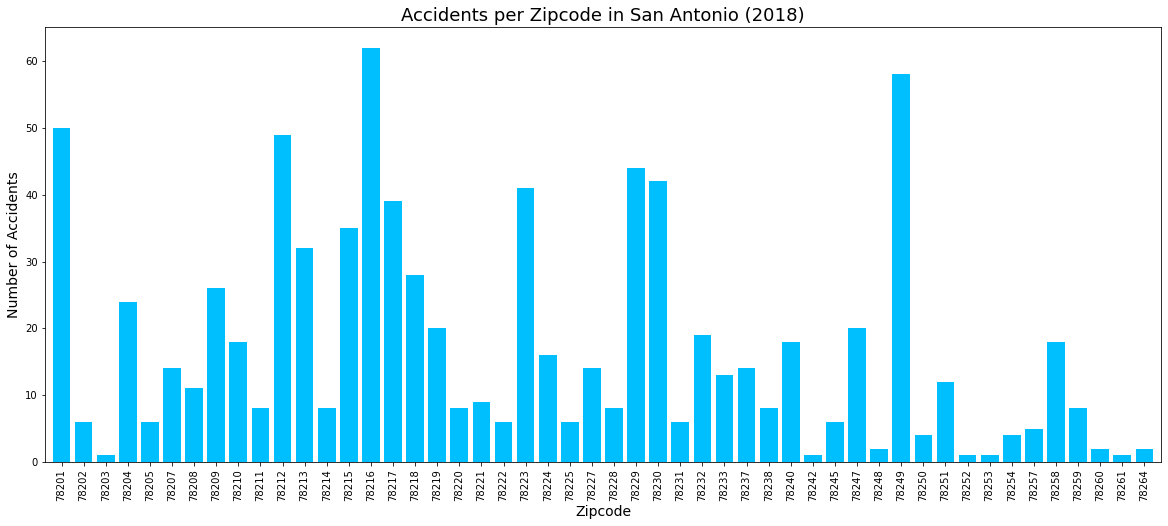

In [7]:
x_axis = zip_counts.index.to_list()
y_axis = zip_counts["Time"].to_list()
plt.figure(figsize=(20, 8))
plt.bar(x_axis, y_axis, color='deepskyblue')
plt.xlim(-0.75, len(x_axis)-0.25)
plt.xticks(rotation="vertical")
plt.title('Accidents per Zipcode in San Antonio (2018)', fontsize=18)
plt.xlabel('Zipcode', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.savefig("Images/acc_per_zip_bar.png")
plt.show()

### Accidents based on side of town
center of San Antonio 29.4241 (lat), 98.4936(long)
Source: https://www.google.com/search?rlz=1C1GGRV_enUS758US758&biw=1366&bih=543&sxsrf=ALeKk032pRNUFt4i_pNxEdtKJ6MWS8YVxw%3A1613274777787&ei=mZ4oYISxL8nOtQb__bagCg&q=lat+and+long+of+center+of+san+antonio&oq=lat+and+long+of+center+of+san+antonio&gs_lcp=Cgdnd3Mtd2l6EAMyBQghEKABMgUIIRCgATIFCCEQqwIyBQghEKsCOgQIIxAnOgUIABCRAjoLCC4QxwEQrwEQkQI6CwguELEDEMcBEKMCOgQIABBDOggIABCxAxCDAToICC4QsQMQgwE6BwgAELEDEEM6BwgAEMkDEEM6CggAEIcCELEDEBQ6BQgAELEDOgcIABCHAhAUOgIIADoHCCMQsAIQJzoECAAQDToJCAAQyQMQFhAeOggIABAWEAoQHjoGCAAQFhAeOggIIRAWEB0QHjoHCCEQChCgAVDF3QNY85AEYK6TBGgBcAJ4AYAB9wGIAfIhkgEHMjAuMTYuM5gBAKABAaoBB2d3cy13aXrAAQE&sclient=gws-wiz&ved=0ahUKEwjE4bfwvOjuAhVJZ80KHf--DaQQ4dUDCA0&uact=5

Instead of using zip codes to determine side of town, using the center points of San Antonio. Any accidents that occured Northwest of the center points will be considered Northwest and so on.

In [8]:
#forloop to calculate side of town
for i, row in sa_df.iterrows():
    if sa_df.loc[i, 'Latitude']> 29.4241 and sa_df.loc[i, "Longitude"]> -98.4936:
        sa_df.loc[i, "Side of Town"] = "Northeast"
    elif sa_df.loc[i, 'Latitude']< 29.4241 and sa_df.loc[i, "Longitude"]> -98.4936: 
        sa_df.loc[i,"Side of Town"] = "Southeast"
    elif sa_df.loc[i, 'Latitude']< 29.4241 and sa_df.loc[i, "Longitude"]< -98.4936: 
        sa_df.loc[i, "Side of Town"] = "Southwest"
    else:
        sa_df.loc[i, "Side of Town"] = "Northwest"

In [9]:
#grouping by side of town to do counts.
group_side = sa_df.groupby('Side of Town')
side_counts = group_side.count()


Chart II: Bar chart based on accidents for side of town.

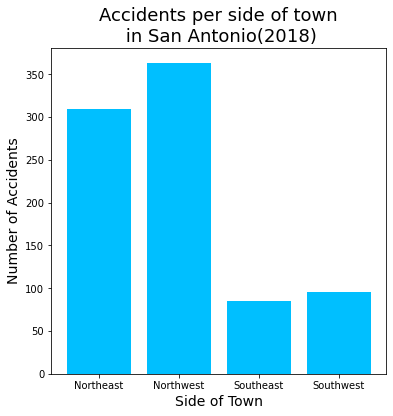

In [10]:
x_axis2 = side_counts.index.tolist()
y_axis2 = side_counts['Time'].tolist()
plt.figure(figsize=(6, 6))
plt.bar(x_axis2, y_axis2, color='deepskyblue')
plt.title("Accidents per side of town\n in San Antonio(2018)", fontsize=18)
plt.xlabel("Side of Town", fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.savefig("Images/acc_side_bar.png")
plt.show()

#### Analyzing accidents based on population

With the help of the census module and census.gov API, pulling in population information for each zip code for 2018.

In [11]:
#pulling in census data
census_data = c.acs5.get(("NAME", "B01003_001E"), {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})


# Final DataFrame
census_pd = census_pd[["Zipcode", "Population"]]

# Visualize
print(len(census_pd))
census_pd.head()

33120


,Zipcode,Population
0,23833,2301.0
1,23850,1268.0
2,23851,13262.0
3,23890,3708.0
4,23302,268.0


Getting only the population information for the zipcodes where accidents occurred. 

In [12]:
#using for loop to match zip codes pulled from previous grouped df to the census df
pop = []
zipcode_list = []
for zipcode in x_axis:
    for i, row in census_pd.iterrows():
        if census_pd.loc[i, 'Zipcode'] == zipcode:
            pop.append(census_pd.loc[i, 'Population'])
            zipcode_list.append(zipcode)
            

New Dataframe for further analysis on population levels.

In [13]:
#making new df with population info
pop_df = pd.DataFrame({"Clean_Zip": zipcode_list, 
                     'Population': pop})
pop_by_zip_df = pd.merge(pop_df, zip_counts["Time"], on='Clean_Zip')


Put the zip codes in bins based on population levels.

In [14]:
bins = [0, 20000, 40000, 80000]
labels = ['small', 'medium', 'large']
pop_by_zip_df['Population_level'] = pd.cut(pop_by_zip_df['Population'], bins, labels=labels, include_lowest=True)


Grouping by bins to get count of accidents

In [15]:
group_by_pop = pop_by_zip_df.groupby('Population_level')
count_of_acc = group_by_pop.sum()
count_of_acc

,Population,Time
Population_level,,
small,156316.0,134
medium,504625.0,277
large,1008684.0,443


Chart III: Bar chart of accidents per zip code size

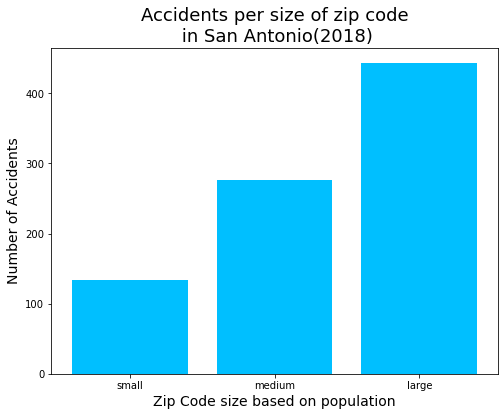

In [16]:
x_axis3 = count_of_acc.index.tolist()
y_axis3 = count_of_acc['Time'].tolist()
plt.figure(figsize=(8, 6))
plt.bar(x_axis3, y_axis3, color='deepskyblue')
plt.title("Accidents per size of zip code\n in San Antonio(2018)", fontsize=18)
plt.xlabel("Zip Code size based on population", fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.savefig("Images/acc_zipsize_bar.png")
plt.show()

In [17]:
#Getting data for each bin based on zipcode size
small_x_axis = []
small_y_axis = []
medium_x_axis = []
medium_y_axis = []
large_x_axis = []
large_y_axis= []
for index, row in pop_by_zip_df.iterrows():
    if pop_by_zip_df.loc[index, "Population_level"] == "small":
        small_x_axis.append(pop_by_zip_df.loc[index, "Clean_Zip"])
        small_y_axis.append(pop_by_zip_df.loc[index, 'Time'])
    elif pop_by_zip_df.loc[index, 'Population_level'] == "medium":
        medium_x_axis.append(pop_by_zip_df.loc[index, "Clean_Zip"])
        medium_y_axis.append(pop_by_zip_df.loc[index, 'Time'])
    else:
        large_x_axis.append(pop_by_zip_df.loc[index, "Clean_Zip"])
        large_y_axis.append(pop_by_zip_df.loc[index, 'Time'])

Chart IV: Bar chart of accidents per small zip codes

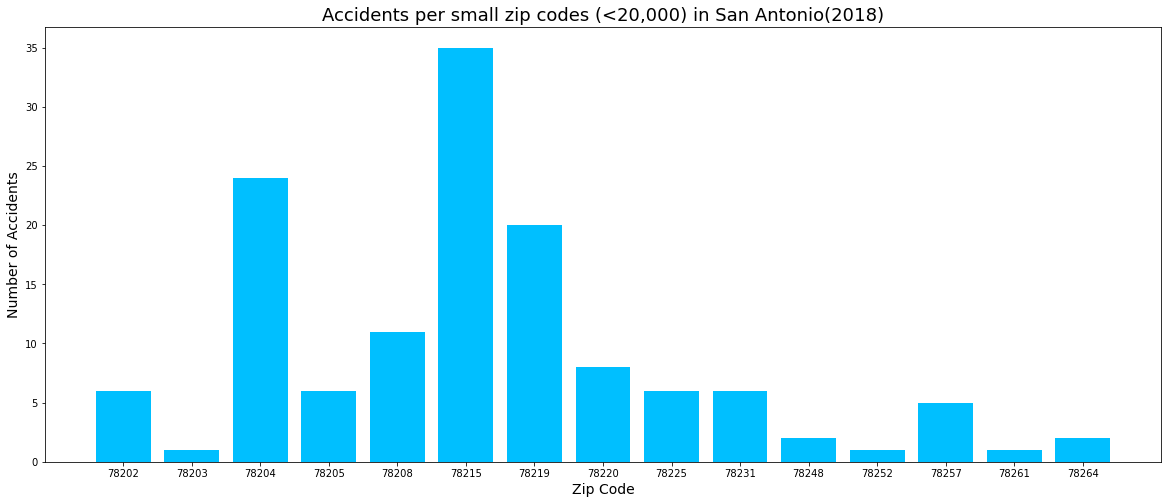

In [18]:
plt.figure(figsize=(20, 8))
plt.bar(small_x_axis, small_y_axis, color="deepskyblue", label="Small Counties (0-20000 pop)")
plt.title("Accidents per small zip codes (<20,000) in San Antonio(2018)", fontsize=18)
plt.xlabel("Zip Code", fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.savefig("Images/acc_small_bar.png")
plt.show()

Chart V: Bar chart of accidents per medium zip codes

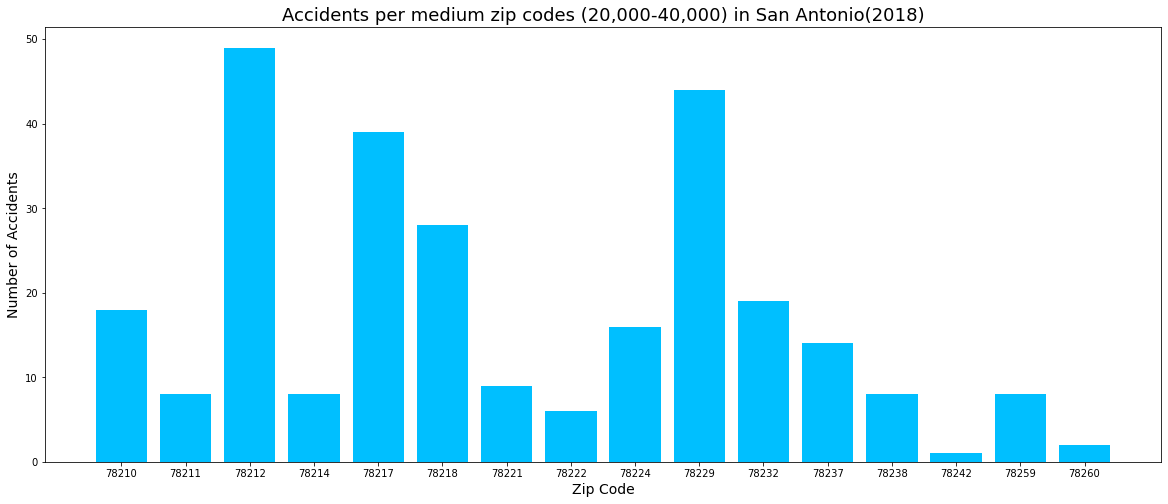

In [19]:
plt.figure(figsize=(20, 8))
plt.bar(medium_x_axis, medium_y_axis, color="deepskyblue", label="Medium Counties (20001-50000 pop)" )
plt.title("Accidents per medium zip codes (20,000-40,000) in San Antonio(2018)", fontsize=18)
plt.xlabel("Zip Code", fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.savefig("Images/acc_medium_bar.png")
plt.show()

Chart VI: Bar chart of accidents per large zip codes

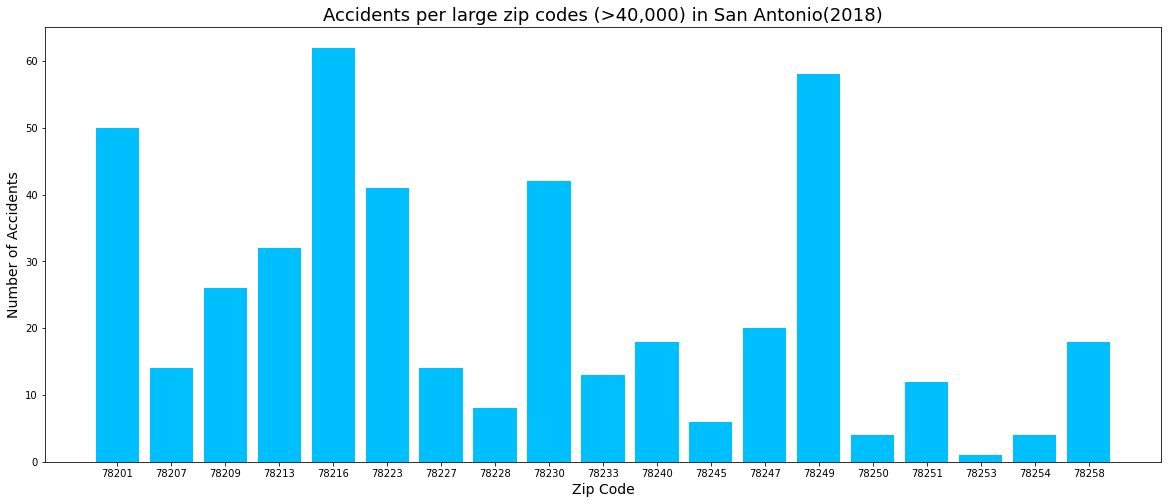

In [20]:
plt.figure(figsize=(20, 8))
plt.bar(large_x_axis, large_y_axis, color='deepskyblue', label="Large Counties (50001-80000 pop)" )
plt.title("Accidents per large zip codes (>40,000) in San Antonio(2018)", fontsize=18)
plt.xlabel("Zip Code", fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.savefig("Images/acc_large_bar.png")
plt.show()

## Summary Statistics
Using the chi square to test hypothesis.

Hypothesis: The areas with a higher population will have more accidents

In [21]:
# total accidents in san antonio
count_of_acc["Time"].sum()

854

Expectations based on hypothesis, accidents split 20% (small), 30% (medium), 50% (large).

In [22]:
#adding expectation column based on hypothesis
count_of_acc['Expected'] = [171, 256, 427]
count_of_acc

,Population,Time,Expected
Population_level,,,
small,156316.0,134,171
medium,504625.0,277,256
large,1008684.0,443,427


Calculating the chi square

In [23]:
# The degree of freedom is 3-1 = 2
# With a p-value of 0.05, the confidence level is 1.00-0.05 = 0.95.
critical_value = stats.chi2.ppf(q = 0.95, df = 2)

In [24]:
# The critical value
critical_value

5.991464547107979

In [25]:
# Run the chi square test with stats.chisquare()
stats.chisquare(count_of_acc['Time'], count_of_acc['Expected'])

Power_divergenceResult(statistic=10.328035819141434, pvalue=0.005718676339370019)

### Conclusion

* Since the chi square value of 10.33 exceeds the critical value of 5.99, we conclude that the results are statistically significant. This proves the hypothesis to be correct, the more populated the zip codes, the more accidents that will occur.

# The best place to drive in San Antonio is in the Southeast side of town in zip code 78203.